# Sentiment Analysis
### Umar Faruk Abdullahi (contactumarfaruk@gmail.com)

### Project Description:
In this project, we train machine learning models for sentiment analysis using the Twitter Sentiment140 dataset. We train the two models to correctly classify tweets as either positive or negative.

The project is separated into four steps:


*   Data Processing and EDA
*   Feature Selection and Engineering
*   Model Training and Evaluation
*   Model Comparison




## Imports

We load all the relevant data science and machine learning libraries required for the execution of the project.

Also, we import utility libraries to aid in our data fetching.

Data is loaded from a remote location if not present in the current runtime.

In [ ]:
!pip install -q transformers datasets accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.9 MB/s eta 0:00:00


In [ ]:
import os
import requests
import random
import re
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from wordcloud import WordCloud

from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve, average_precision_score, roc_curve, auc, mean_squared_error, mean_squared_error, r2_score, accuracy_score, classification_report, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec

from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import DistilBertForSequenceClassification
from transformers import DistilBertTokenizer
from datasets import load_metric
from datasets import Dataset

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
filename = 'MP2_Sentiment140.tsv'

if not os.path.exists(filename):
  print("Data not present locally... Fetching....")

  with open(filename,'w', encoding="utf-8") as f:
    url = f"https://raw.githubusercontent.com/farouqu/ds_proj_1/main/{filename}"
    data = requests.get(url).text
    f.write(data)
    print("Data loaded.")

Data not present locally... Fetching....
Data loaded.


In [ ]:
data = pd.read_csv(filename, sep='\t', header=0)

In [ ]:
data.head()

,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   sentiment_label  160000 non-null  int64 
 1   tweet_text       160000 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [ ]:
data.sentiment_label.value_counts()

4    80000
0    80000
Name: sentiment_label, dtype: int64

In [ ]:
label_to_sentiment = {0:"Negative", 4:"Positive"}

def label_decoder(label):
  return label_to_sentiment[label]
data.sentiment_label = data.sentiment_label.apply(lambda x: label_decoder(x))

In [ ]:
data.head()

,sentiment_label,tweet_text
0,Positive,"@elephantbird Hey dear, Happy Friday to You A..."
1,Positive,Ughhh layin downnnn Waiting for zeina to co...
2,Negative,"@greeniebach I reckon he'll play, even if he's..."
3,Negative,@vaLewee I know! Saw it on the news!
4,Negative,very sad that http://www.fabchannel.com/ has c...


Text(0.5, 1.0, 'Sentiment Data Distribution')

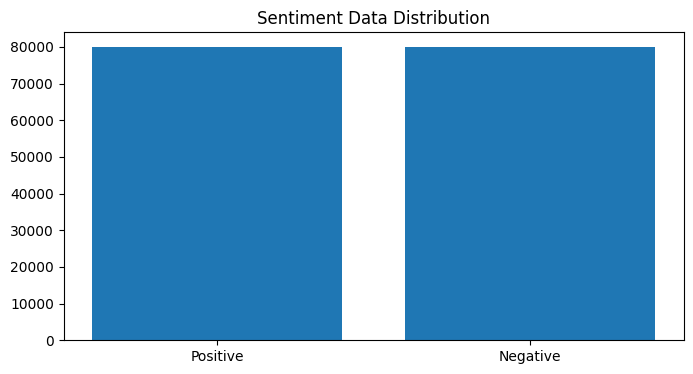

In [ ]:
val_count = data.sentiment_label.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

We can see that the dataset contains a balanced distribution of **Positive** and **Negative** sentiments. This is vital in training machine learning models as unbalanced datasets can introduce bias in the model and cause a weaker performance in one of the classes

In [ ]:
random_idx_list = [random.randint(1,len(data.tweet_text)) for i in range(10)]
data.loc[random_idx_list,:].head(10)

,sentiment_label,tweet_text
99184,Negative,okay i am still here not ready to climb into ...
105251,Negative,Not really into this whole business of paying ...
6459,Negative,Got results today. More studying tomorrow
129310,Negative,I don't sleep when the moon is up but when the...
57167,Positive,"Hello , I am into making cards and playing wit..."
30028,Positive,Hungry...Sleepy... but I bought the coolest ou...
18553,Positive,"@daniellehough there you go, i have started to..."
27154,Positive,"@RealBlackWidow omg, yeah that's the only thin..."
16244,Negative,@dontebee......did you eat your plate of food ...
62104,Positive,Off to bed. EW. School photos tomorrow. My las...


We display a list of some random tweets to have a look at the content and get to understand the text better before progressing to the preprocessing stage.

Below, we display a WordCloud highlighting the words most common in texts labeled with **Positive** sentiment.

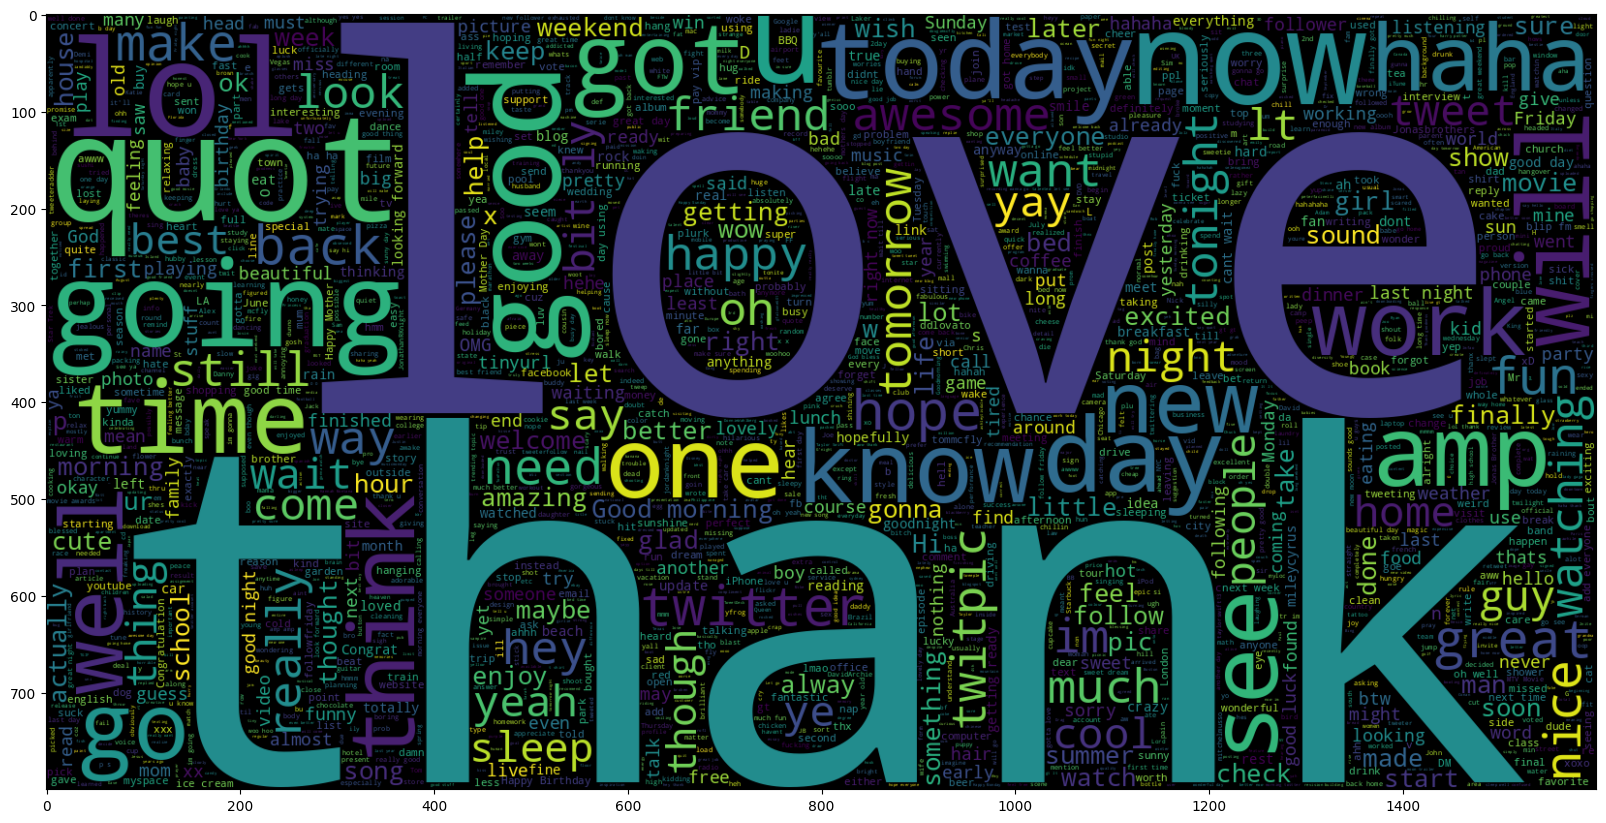

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.sentiment_label == 'Positive'].tweet_text))
plt.imshow(wc , interpolation = 'bilinear')

We also display the corresponding WordCloud for the most common words with **Negative** sentiment as well.

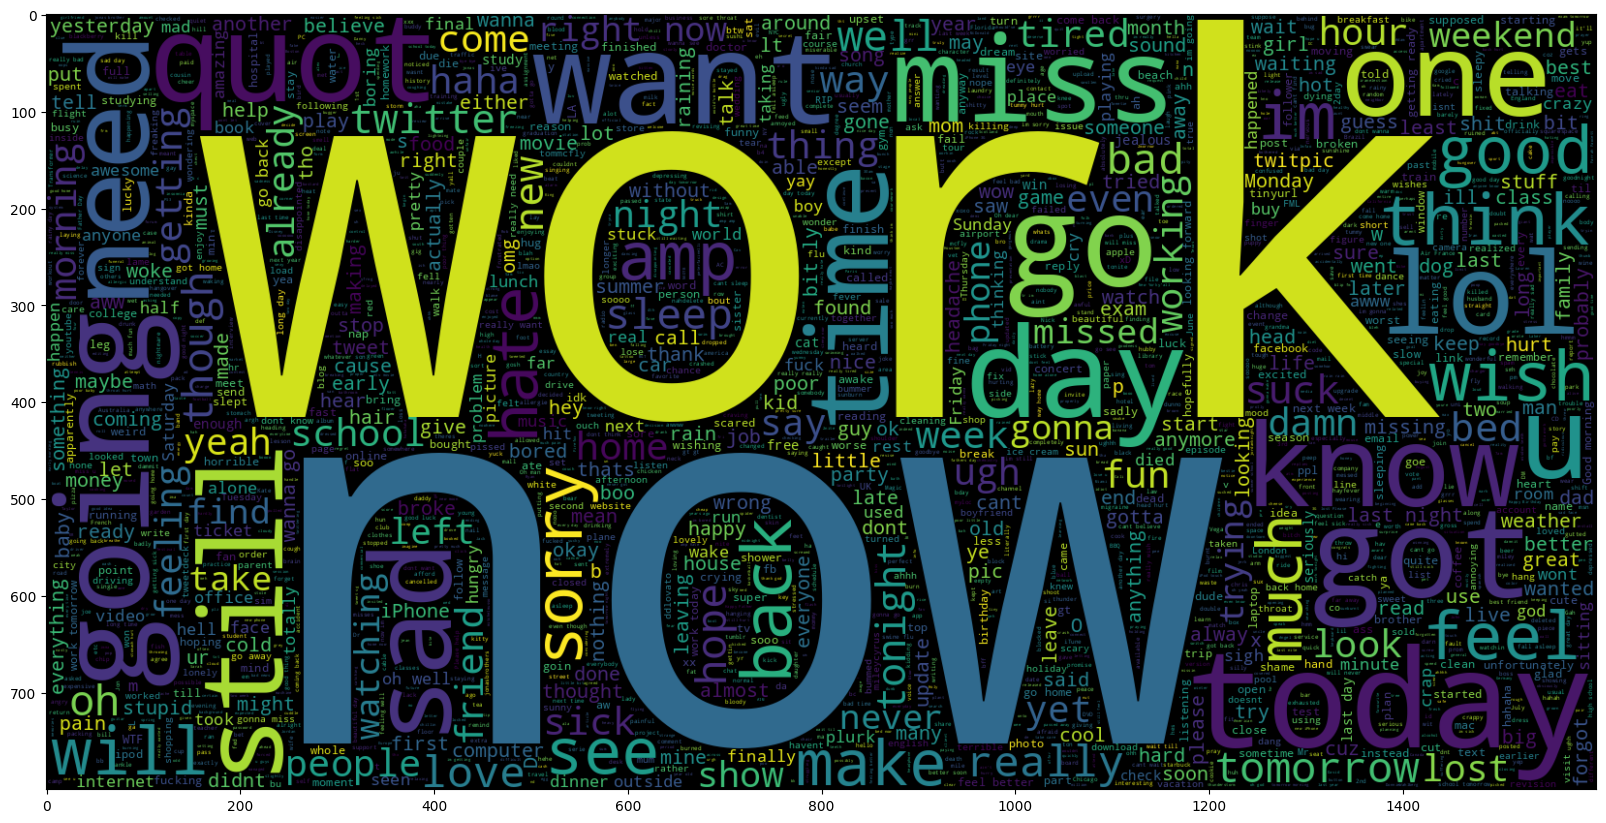

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.sentiment_label == 'Negative'].tweet_text))
plt.imshow(wc , interpolation = 'bilinear')

## Data Processing

In this stage, which can be argued as the most important step in any Natural Language Processing (NLP) project, we perform text processing to clean our text and use standard NLP techniques to prepare the text for further vectored processing to train our machine learning models. The steps performed in this stage are as follows:



1.   **Removal of unwanted characters**: Since the source of the text is Tweets, one of the most common character occurances is then the **@** sign which signifies usernames. We remove the tag and subsequently remove unwanted spaces and single character words. This is because a single character words would contain no context and therefore not be useful for a machine learning model.
2.   **Tokenization**: This refers to the process of breaking down a text or a sequence of characters into smaller units called tokens. These tokens can be words, phrases, symbols, or other meaningful elements, depending on the context and the specific task at hand. Tokenization is a fundamental step in NLP preprocessing because it enables computers to understand and process human language by treating each token as a discrete unit.
3.  **Text Normalization**: The most common text normalization techniques are stemming and lemmatization. **Stemming** refers to the process of reducing words to their root or base form, known as the stem while **Lemmatization** which the process of reducing words to their base or dictionary form, known as the lemma. Unlike stemming, which simply chops off affixes from words, lemmatization takes into account the morphological analysis of words and aims to transform them into their canonical or dictionary form. We proceed with Lemmatization.

We then store the clean tweets in a separate column for further processing.


In [ ]:
def clean_tweet(tweet):

    tweet = BeautifulSoup(tweet, 'html.parser').get_text()

    tweet = re.sub(r'@[^\s]+', '', tweet)

    tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)
    tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', tweet)
    tweet = re.sub(r'\s+', ' ', tweet)

    return tweet.strip()

In [ ]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()

    words = word_tokenize(text)

    words = [lemmatizer.lemmatize(word) for word in words]

    processed_text = ' '.join(words)

    return processed_text

In [ ]:
data['cleaned_text'] = data['tweet_text'].apply(clean_tweet)

<ipython-input-14-492dbb447ee1>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  tweet = BeautifulSoup(tweet, 'html.parser').get_text()


In [ ]:
data['cleaned_text'] = data['cleaned_text'].apply(preprocess_text)

In [ ]:
data['cleaned_text'].head(20)

0     hey dear happy friday to you already had your ...
1     ughhh layin downnnn waiting for zeina to cook ...
2     reckon hell play even if he not but know nothi...
3                               know saw it on the news
4     very sad that httpwwwfabchannelcom ha closed d...
5     who sings remember alwaysss hear it on radio b...
6              with god on ur side anything is possible
7                                      why being stupid
8     having delved back into the gut of expression ...
9                                awww take him with you
10     the video on vh is much better than the tube one
11    i ran out of champagne wonder if call my broth...
12                    wish wa going to the show tonight
13    doing homeworkthen bedwaking up at is gon na b...
14    ashleyltmsyf hey ashley when will the hush hus...
15    scratch that enjoy seein people that left for ...
16    hey im good sorry took so long reply and im ju...
17    good morning youre up early chilling and c

The sample above shows the text after it was processed

In [ ]:
label_encoder = LabelEncoder()
data['sentiment_label'] = label_encoder.fit_transform(data['sentiment_label'])

# Modelling

In this section, we perform further feature engineering with various techniques and then proceed to train machine learning models based on the engineered features.

## Term Frequency Vectorization

The TF-IDF (Term Frequency-Inverse Document Frequency) vectorizer is a powerful tool in natural language processing (NLP) used for extracting features from text data. It operates by transforming a collection of raw text documents into a matrix of TF-IDF features. TF-IDF consists of two main components: Term Frequency (TF) and Inverse Document Frequency (IDF). TF measures how often a term appears in a document relative to the total number of terms in that document, while IDF measures the importance of a term across the entire corpus, assigning higher weights to terms that are rare across documents but common within a specific document. The TF-IDF score of a term in a document is the product of its TF and IDF scores, indicating the term's importance in the context of the entire corpus.

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X_vect = tfidf_vectorizer.fit_transform(data['cleaned_text'])

In [ ]:
X_train_v, X_test_v, y_train_v, y_test_v = train_test_split(X_vect, data['sentiment_label'], test_size=0.2, random_state=42)


### Logistic Regression

In [ ]:
lg_model = LogisticRegression(max_iter=1000)
lg_model.fit(X_train_v, y_train_v)

LogisticRegression(max_iter=1000)

In [ ]:
lg_pred = lg_model.predict(X_test_v)

lg_vec_accuracy = accuracy_score(y_test_v, lg_pred)

print("Logistic Regression Accuracy:", lg_vec_accuracy)
print("Logistic Regression Mean Squared Error (MSE):", mean_squared_error(y_test_v, lg_pred))
print("Logistic Regression Classification Report:\n", classification_report(y_test_v, lg_pred))


Logistic Regression Accuracy: 0.7843125
Logistic Regression Mean Squared Error (MSE): 0.2156875
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.77      0.78     16002
           1       0.77      0.80      0.79     15998

    accuracy                           0.78     32000
   macro avg       0.78      0.78      0.78     32000
weighted avg       0.78      0.78      0.78     32000



### LinearSVC

In [ ]:
l_svc = svm.LinearSVC(penalty='l2', loss='squared_hinge', C=1.0)
l_svc.fit(X_train_v, y_train_v)

LinearSVC()

In [ ]:
lsvc_pred = l_svc.predict(X_test_v)

lsvc_vec_accuracy = accuracy_score(y_test_v, lsvc_pred)

print("Linear SVC Accuracy:", lsvc_vec_accuracy)
print("Linear SVC Mean Squared Error (MSE):", mean_squared_error(y_test_v, lsvc_pred))
print("Linear SvC Classification Report:\n", classification_report(y_test_v, lsvc_pred))


Linear SVC Accuracy: 0.77584375
Linear SVC Mean Squared Error (MSE): 0.22415625
Linear SvC Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.76      0.77     16002
           1       0.77      0.79      0.78     15998

    accuracy                           0.78     32000
   macro avg       0.78      0.78      0.78     32000
weighted avg       0.78      0.78      0.78     32000



### Random Forest

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10)
rf_model.fit(X_train_v, y_train_v)

RandomForestClassifier(max_depth=10)

In [ ]:
rf_pred = rf_model.predict(X_test_v)

rf_vec_accuracy = accuracy_score(y_test_v, rf_pred)

print("Random Forest Accuracy:", rf_vec_accuracy)
print("Random Forest Mean Squared Error (MSE):", mean_squared_error(y_test_v, rf_pred))
print("Random Forest Classification Report:\n", classification_report(y_test_v, rf_pred))


Random Forest Accuracy: 0.7231875
Random Forest Mean Squared Error (MSE): 0.2768125
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.66      0.71     16002
           1       0.70      0.78      0.74     15998

    accuracy                           0.72     32000
   macro avg       0.73      0.72      0.72     32000
weighted avg       0.73      0.72      0.72     32000



### SGD Classifier

In [ ]:
sgd = SGDClassifier(loss='log_loss', penalty='l2', alpha=0.0001, shuffle=True, epsilon=0.1, eta0=0.001, learning_rate='adaptive', early_stopping=True, validation_fraction=0.1)
sgd.fit(X_train_v, y_train_v)

SGDClassifier(early_stopping=True, eta0=0.001, learning_rate='adaptive',
              loss='log_loss')

In [ ]:
sgd_pred = sgd.predict(X_test_v)

sgd_vec_accuracy = accuracy_score(y_test_v, sgd_pred)

print("SGD Classifier Accuracy:", sgd_vec_accuracy)
print("SGD Classifier Mean Squared Error (MSE):", mean_squared_error(y_test_v, sgd_pred))
print("SGD Classifier Classification Report:\n", classification_report(y_test_v, sgd_pred))


SGD Classifier Accuracy: 0.7525625
SGD Classifier Mean Squared Error (MSE): 0.2474375
SGD Classifier Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.74      0.75     16002
           1       0.75      0.76      0.75     15998

    accuracy                           0.75     32000
   macro avg       0.75      0.75      0.75     32000
weighted avg       0.75      0.75      0.75     32000



We compare the performance of the trained machine learning models based on the same vectorization technique. The figure belows shows the summary of the performance:

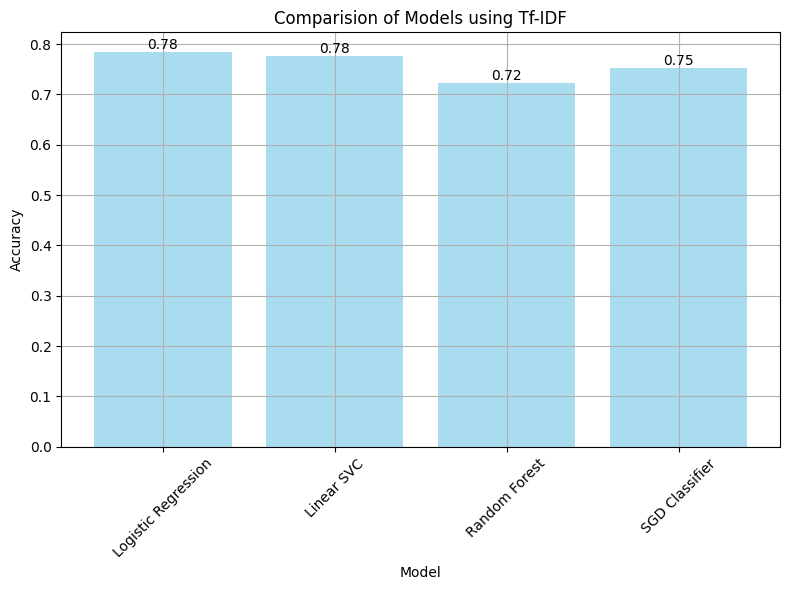

In [ ]:
model_accuracies = {
    "Logistic Regression": lg_vec_accuracy,
    "Linear SVC": lsvc_vec_accuracy,
    "Random Forest": rf_vec_accuracy,
    "SGD Classifier": sgd_vec_accuracy
}

plt.figure(figsize=(8, 6))
bars = plt.bar(model_accuracies.keys(), model_accuracies.values(), color='skyblue', alpha=0.7)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparision of Models using Tf-IDF')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Word2Vec

We then try another approach of using the popular Word2Vec vectorization technique in an aim of improving the performance of our trained models.

Word2Vec is a technique in natural language processing that helps computers understand the meaning of words by representing them as numerical vectors. Word2Vec learns these representations by analyzing large amounts of text data. It does this by training neural network models to predict words based on their surrounding context or to predict context words given a target word. As a result, similar words end up with similar vector representations in a continuous vector space. These word embeddings capture semantic relationships between words, enabling computers to better understand and process natural language.

In [ ]:
# Constants
MAX_LEN = 30
EMBEDDING_DIM = 200

In [ ]:
tokenized_tweet = data['cleaned_text'].apply(lambda x: x.split())

In [ ]:
model_w2v = Word2Vec(
            tokenized_tweet,
            vector_size=EMBEDDING_DIM,
            window=5,
            min_count=2,
            sg = 1,
            hs = 0,
            negative = 10,
            workers= 4,
            seed = 34
)

In [ ]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v.wv[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [ ]:
embedding_matrix = np.zeros((len(tokenized_tweet), EMBEDDING_DIM))

for i in range(len(tokenized_tweet)):
    embedding_matrix[i,:] = word_vector(tokenized_tweet[i], EMBEDDING_DIM)
wordvec_df = pd.DataFrame(embedding_matrix)
wordvec_df.shape

(160000, 200)

In [ ]:
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(embedding_matrix, data['sentiment_label'], test_size=0.2, random_state=42)

### Logistic Regression

In [ ]:
lg_model = LogisticRegression(max_iter=1000)
lg_model.fit(X_train_e, y_train_e)

LogisticRegression(max_iter=1000)

In [ ]:
lg_pred = lg_model.predict(X_test_e)

lg_w2v_accuracy = accuracy_score(y_test_e, lg_pred)

print("Logistic Regression Accuracy:", lg_w2v_accuracy)
print("Logistic Regression SVC Mean Squared Error (MSE):", mean_squared_error(y_test_e, lg_pred))
print("Logistic Regression SvC Classification Report:\n", classification_report(y_test_e, lg_pred))


Logistic Regression Accuracy: 0.757125
Logistic Regression SVC Mean Squared Error (MSE): 0.242875
Logistic Regression SvC Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.75      0.76     16002
           1       0.75      0.76      0.76     15998

    accuracy                           0.76     32000
   macro avg       0.76      0.76      0.76     32000
weighted avg       0.76      0.76      0.76     32000



### Linear SVC

In [ ]:
l_svc = svm.LinearSVC(penalty='l2', loss='squared_hinge', C=1.0)
l_svc.fit(X_train_e, y_train_e)

LinearSVC()

In [ ]:
lsvc_pred = l_svc.predict(X_test_e)

lsvc_w2v_accuracy = accuracy_score(y_test_e, lsvc_pred)

print("Linear SVC Accuracy:", lsvc_w2v_accuracy)
print("Linear SVC Mean Squared Error (MSE):", mean_squared_error(y_test_e, lsvc_pred))
print("Linear SvC Classification Report:\n", classification_report(y_test_e, lsvc_pred))


Linear SVC Accuracy: 0.7579375
Linear SVC Mean Squared Error (MSE): 0.2420625
Linear SvC Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.75      0.76     16002
           1       0.75      0.77      0.76     15998

    accuracy                           0.76     32000
   macro avg       0.76      0.76      0.76     32000
weighted avg       0.76      0.76      0.76     32000



### Random Forest

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10)
rf_model.fit(X_train_e, y_train_e)

RandomForestClassifier(max_depth=10)

In [ ]:
rf_pred = rf_model.predict(X_test_e)

rf_w2v_accuracy = accuracy_score(y_test_e, rf_pred)

print("Random Forest Accuracy:", rf_w2v_accuracy)
print("Random Forest Mean Squared Error (MSE):", mean_squared_error(y_test_e, rf_pred))
print("Random Forest Classification Report:\n", classification_report(y_test_e, rf_pred))


Random Forest Accuracy: 0.7328125
Random Forest Mean Squared Error (MSE): 0.2671875
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.74      0.74     16002
           1       0.74      0.72      0.73     15998

    accuracy                           0.73     32000
   macro avg       0.73      0.73      0.73     32000
weighted avg       0.73      0.73      0.73     32000



### SGD Classifier

In [ ]:
sgd = SGDClassifier(loss='log_loss', penalty='l2', alpha=0.0001, shuffle=True, epsilon=0.1, eta0=0.001, learning_rate='adaptive', early_stopping=True, validation_fraction=0.1)
sgd.fit(X_train_e, y_train_e)

SGDClassifier(early_stopping=True, eta0=0.001, learning_rate='adaptive',
              loss='log_loss')

In [ ]:
sgd_pred = sgd.predict(X_test_e)

sgd_w2v_accuracy = accuracy_score(y_test_e, sgd_pred)

print("SGD Classifier Accuracy:", sgd_w2v_accuracy)
print("SGD Classifier Mean Squared Error (MSE):", mean_squared_error(y_test_e, sgd_pred))
print("SGD Classifier SvC Classification Report:\n", classification_report(y_test_e, sgd_pred))


SGD Classifier Accuracy: 0.74934375
SGD Classifier Mean Squared Error (MSE): 0.25065625
SGD Classifier SvC Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.75      0.75     16002
           1       0.75      0.75      0.75     15998

    accuracy                           0.75     32000
   macro avg       0.75      0.75      0.75     32000
weighted avg       0.75      0.75      0.75     32000



We also then compare the performance of the trained machine learning models based on the Word2Vec technique. The figure belows shows the summary of the performance:

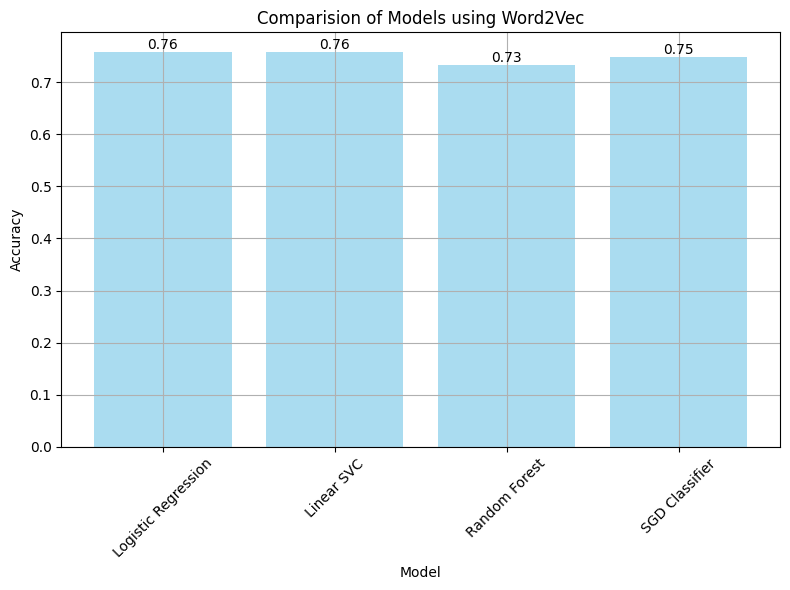

In [ ]:
model_accuracies = {
    "Logistic Regression": lg_w2v_accuracy,
    "Linear SVC": lsvc_w2v_accuracy,
    "Random Forest": rf_w2v_accuracy,
    "SGD Classifier": sgd_w2v_accuracy
}

plt.figure(figsize=(8, 6))
bars = plt.bar(model_accuracies.keys(), model_accuracies.values(), color='skyblue', alpha=0.7)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparision of Models using Word2Vec')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Discuss the difference in performance to TF-IDF here**

## Deep Learning with BERT

The techniques we tried above are based on traditional machine learning approaches. To further enhance the performance of our model, we explore the usage of state-of-the-art pre-trained deep learning models that we will fine-tune with our data.

Fine-tuning is a process in machine learning where a pre-trained model is further trained on a specific task or dataset to adapt its knowledge and parameters to better suit that particular task. Instead of training a model from scratch, fine-tuning starts with a model that has already been trained on a large dataset for a general task, in our case - natural language processing. Then, the model's parameters are adjusted or fine-tuned by training it on a smaller, task-specific dataset like the TwitterSentiment140 in our project.

To achieve this, we will be using a model called **BERT**. BERT, short for Bidirectional Encoder Representations from Transformers, is a pre-trained language model created by Google in 2018. It's really good at understanding the meaning of words in a sentence because it looks at both the words before and after each word. BERT is trained on a lot of text data using a special technique, and then it can be used for different tasks like understanding what a sentence means, finding important information in a paragraph, or answering questions. We will be employing BERT as the base model for our tokenization and modelling process through using popular machine learning libraries from **HuggingFace**

The steps are listed below:

1. **Load Pre-trained BERT Model**: Using Hugging Face's `from_pretrained()` function to load a pre-trained BERT model.

2. **Prepare Data**: This involves formatting the dataset in a way that BERT can understand. We tokenized the text data and converted it into input features that BERT expects.

3. **Fine-tune BERT Model**: We fine-tune the pre-trained BERT model on our converted Twitter dataset using the `Trainer` module from the Hugging Face library.

4. **Evaluate Model Performance**: Lastly, we evaluate the performance of the fine-tuned BERT model using a separate validation dataset to assess its accuracy and effectiveness on our task.

In [ ]:
torch.cuda.is_available()

True

In [ ]:
bert_data = data.drop('tweet_text', axis=1)
bert_data.reset_index(drop=True, inplace=True)

In [ ]:
new_column_names = ['label', 'text']
bert_data.rename(columns=dict(zip(bert_data.columns, new_column_names)), inplace=True)

In [ ]:
bert_data_train, bert_data_eval = train_test_split(bert_data, test_size=0.2, random_state=42)
bert_data_val, bert_data_test = train_test_split(bert_data_eval, test_size=0.5, random_state=42)

In [ ]:
train_dataset = Dataset.from_pandas(bert_data_train)
val_dataset = Dataset.from_pandas(bert_data_val)
test_dataset = Dataset.from_pandas(bert_data_test)

**Note**: The model was trained using a GPU accelerator on a cloud environment. Training the model on Google Colab would take a large amount of time, and much larger time if using the CPU (if GPU or TPU is unavailable).

Refer to [Model Evaluation](#scrollTo=2lZpwzLOPFwd&line=1&uniqifier=1), to load the trained model and evaluate on the test dataset.

In [ ]:
bert_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def preprocess_function(doc):
   return bert_tokenizer(doc["text"], truncation=True)

In [ ]:
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_val = val_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/128000 [00:00<?, ? examples/s]

Map:   0%|          | 0/128000 [00:00<?, ? examples/s]

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer)

In [ ]:
bert_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy")
   load_f1 = load_metric("f1")

   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
   return {"accuracy": accuracy, "f1": f1}

**Note: Training the model without hardware acceleration will take a lot of time ~13hrs. The model was trained on a GPU intensive system and stored remotely. The model can be loaded from the remote source and evaluated in the following cell: [Model Evaluation](#scrollTo=2lZpwzLOPFwd&line=1&uniqifier=1)**

In [ ]:
training_args = TrainingArguments(
   output_dir='./',
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=4,
   weight_decay=0.01,
   save_strategy="epoch",
   push_to_hub=False,
)

trainer = Trainer(
   model=bert_model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=bert_tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()
trainer.evaluate()

In [ ]:
loss_values = [d.get('loss') for d in trainer.state.log_history]
epochs = [d['epoch'] for d in trainer.state.log_history]

plt.plot(epochs, loss_values, marker='o')
plt.title('Loss over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

**Refer to [Evaluating Trained Model](#scrollTo=2lZpwzLOPFwd&line=1&uniqifier=1) below to evaluate already trained model.**

### Evaluating Trained Model

We download the trained model from the remote source - HuggingFace:

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained("ufakz/sentiment")
distil_tokenizer = DistilBertTokenizer.from_pretrained("ufakz/sentiment")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

In [ ]:
def tokenize_distil_bert(doc):
   return distil_tokenizer(doc["text"], truncation=True)

In [ ]:
test_encoding = test_dataset.map(tokenize_distil_bert, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

In [ ]:
predict_trainer = Trainer(model=model, tokenizer=distil_tokenizer)
predictions = predict_trainer.predict(test_encoding)

In [ ]:
probs = predictions.predictions[:, 1]

In [ ]:
fpr, tpr, thresholds = roc_curve(test_dataset["label"], probs)
roc_auc = auc(fpr, tpr)
cm = confusion_matrix(test_dataset["label"], np.argmax(predictions.predictions, axis=1))
accuracy = accuracy_score(test_dataset["label"], np.argmax(predictions.predictions, axis=1))
f1 = f1_score(test_dataset["label"], np.argmax(predictions.predictions, axis=1))

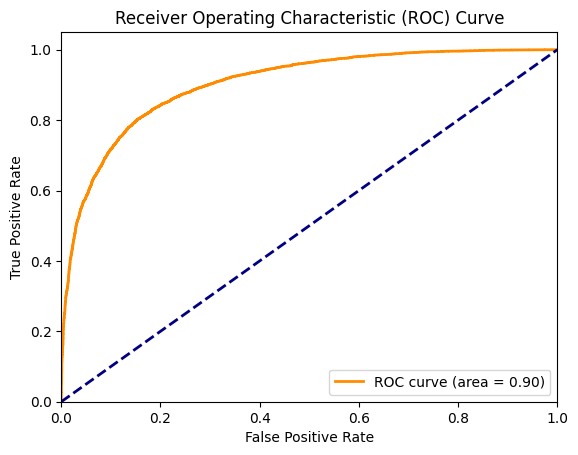

In [ ]:
# Show the ROC/AUC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

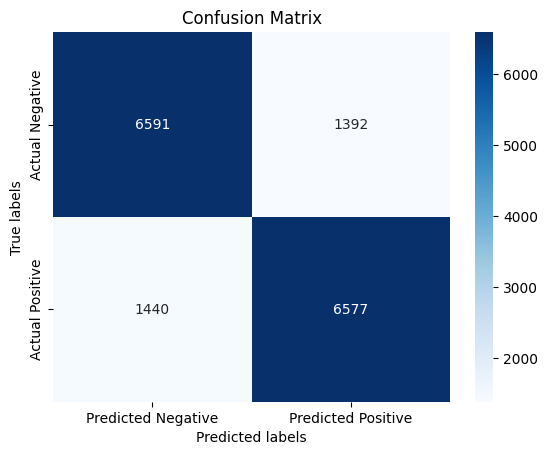

In [ ]:
# Show confusion matrix
plt.figure()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

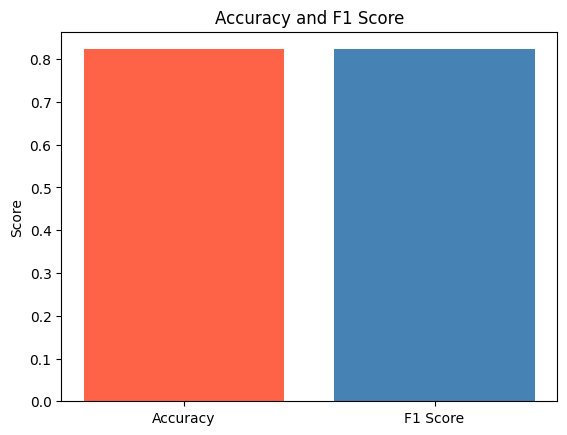

In [ ]:
scores = [accuracy, f1]
labels = ['Accuracy', 'F1 Score']
colors = ['#ff6347', '#4682b4']  # Red and blue colors
bars = plt.bar(labels, scores, color=colors)
plt.ylabel('Score')
plt.title('Accuracy and F1 Score')
plt.show()

From the results we got, we can that the deep learning model performed better than all the previously trained machine learning models with an accuracy of 82%. Deep learning often outperforms traditional machine learning methods in natural language processing (NLP) tasks like sentiment analysis due to its ability to capture complex patterns and relationships within text data. These models can effectively capture contextual information, long-range dependencies, and subtle semantic nuances present in natural language, enabling them to learn more robust and expressive representations of text. Additionally, deep learning models can benefit from pre-trained language representations, such as word embeddings or transformer-based models like BERT, which have been trained on large corpora of text data, allowing them to leverage the knowledge encoded in these representations for improved performance on downstream tasks like sentiment analysis like we did in this project.